# Example notebook for analysing and plotting the paper figures in Google Colab
### [OpenScope Credit Assignment repository](https://github.com/colleenjg/OpenScope_CA_Analysis)
### [Gillon _et al._, 2021, _bioRxiv_](https://www.biorxiv.org/content/10.1101/2021.01.15.426915v2)


---
## 1. Setup

In [1]:
# @markdown ### a. Install **CondaColab** in order to use Conda in a Google Colab, then **wait**.
# @markdown ### _Google Colab only step_

# Adapted from https://stackoverflow.com/questions/1051254/check-if-python-package-is-installed
# and https://datascience.stackexchange.com/questions/75948/how-to-setup-and-run-conda-on-google-colab
import subprocess
import sys

reqs = subprocess.check_output([sys.executable, '-m', 'pip', 'freeze'])
installed_packages = [r.decode().split('==')[0] for r in reqs.split()]

if "condacolab" in installed_packages:
    print("CondaColab is already installed. Checking installation...")
    import condacolab
    condacolab.check()
else:
    print("Installing CondaColab...")
    # first, uninstall matplotlib (seems to cause problems, otherwise, if 
    # a different version is installed later)
    !pip uninstall -y -q matplotlib

    !pip install -q condacolab
    import condacolab
    condacolab.install()

Installing CondaColab...
⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:37
🔁 Restarting kernel...


In [ ]:
# @markdown =============================
# @markdown ### **_Do not run this cell._**
# @markdown ### _Instead, wait until Step 1a has **completely finished running**, then run the next cells._
# @markdown For CondaColab to work properly, the python kernel must be allowed 
# @markdown to **fully restart** before the next cell are run. <br>
# @markdown Otherwise, errors related to package versions may arise after new 
# @markdown packages are installed in Step 1c.

# @markdown =============================

raise RuntimeError(
    "Do not run this cell! Instead, wait until Step 1a is has completely "
    "finished running. Then continue running the cells in the notebook, "
    "skipping this one. If this cell was run before Step 1a had finished "
    "running, make sure to restart the kernel manually "
    "(Runtime -> Restart runtime), before continuing."
    )

In [1]:
# @markdown ### b. Download code from the **OpenScope_CA_Analysis** repository on GitHub.

%%bash

# ensure that we are in the main directory
cd /content 

# If the repository does not already exist, download it.
if [ -d "OpenScope_CA_Analysis" ]; then
    echo "OpenScope_CA_Analysis repository has already been downloaded."
else
    echo "Downloading OpenScope_CA_Analysis repository from GitHub..."
    git clone git://github.com/colleenjg/OpenScope_CA_Analysis.git --quiet
fi

In [2]:
# @markdown ### c. Install **`osca`** python packages.

print("Installing `osca` environment packages (may take a few minutes)...\n")

# NOTE: Normally, we would simply run:
# `conda env create -f OpenScope_CA_Analysis/osca.yml`

# However, on Google Colab, we must instead install the `osca` packages into 
# the base environment. 
!conda env update -q -n base -f OpenScope_CA_Analysis/osca.yml # Google Colab only

Installing `osca` environment packages (may take a few minutes)...

Solving environment: ...working... done
Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done
Installing pip dependencies: ...working... done


### d. Download data from  the [Dandi archive](https://gui.dandiarchive.org/#/dandiset/000037).
Here, we will only download **session 1 data** (11 files) for all subjects, into a directory called `data`, as the same level as the `OpenScope_CA_Analysis` directory.

To do so, we first **move into the `OpenScope_CA_Analysis` repository**, from which we can launch scripts.

We then **download the data** using `sess_util/sess_download_util.py`. This will take a few minutes. 

**Note:** Files that have _already_ been fully downloaded will **not** be redownloaded.

In [3]:
%cd -q /content/OpenScope_CA_Analysis

print("Downloading data from Dandi (may take a few minutes)...\n")
%run sess_util/sess_download_util.py --sess_ns 1 --output ../data


Identifying the URLs of dandi assets to download...
PATH                                              SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-408021_ses-20180926T172917_behavior+ophys.nwb 238.0 MB 238.0 MB         100%    ok    done                   
Summary:                                          238.0 MB 238.0 MB                       1 done                 
                                                           100.00%                                               
PATH                                              SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-411771_ses-20181003T174857_behavior+ophys.nwb 230.3 MB 230.3 MB         100%    ok    done                   
Summary:                                          230.3 MB 230.3 MB                       1 done                 
                                                           100.00%                                               
PATH                               

---
## 2. Adjust a few settings
### _Google Colab only step_

In [4]:
# @markdown - Change display to wrap text to window size.
# Code from https://stackoverflow.com/questions/58890109/line-wrapping-in-collaboratory-google-results
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

# @markdown - Set an environment variable that controls maximum memory use when 
# @markdown performing permutation analyses.
%env LIM_E6_SIZE=100

# @markdown - Filter warnings related to (1) multiprocessing performance and (2) 
# @markdown missing Arial font.
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message="A worker stopped")
warnings.filterwarnings("ignore", category=UserWarning, message="Requested font")

# @markdown - Set logging and warnings format.
from util import logger_util

# @markdown - Load matplotlib
# It seems to always fail to show plots inline, the first time, 
# so I'm just plotting a dummy plot.
from matplotlib import pyplot as plt
plt.plot(range(20))
plt.close("all")

env: LIM_E6_SIZE=100
Generating new fontManager, this may take some time...


---
## 3. Run paper analyses

All subsequent code should be run from inside the OpenScope_CA_Analysis repository.

In [5]:
%cd -q /content/OpenScope_CA_Analysis

We can now run some paper analyses and plot them.

We use the `run_paper_figures.py` script in the main directory of the OpenScope_CA_Analysis directory, with the following arguments:
- `datadir`: path to the downloaded data
- `output`: main directory in which to store the analysis data and plots
- `overwrite`: if included, existing analysis data and plots are overwritten
- `figure`: figure to plot (either `all` or a specific figure)
- `panel`: panel to plot (either `all` or a specific panel)
- `parallel`: if included, analyses are parallelized across available CPUs


In [6]:
# Uncomment the code below to see descriptions for all arguments
# %run run_paper_figures.py --help

### Fig. 1C



________________________________________________________________________________
Fig. 1C. Running analysis and producing plot: Example projections of 2p imaging planes.

- Minor manual formatting adjustments may be missing.

Loading 4 session(s)...


  0%|          | 0/4 [00:00<?, ?it/s]


Compiling imaging plane projection examples.
    Rasterizing imaging plane images...

Figures saved under /content/paper_figures/Fig1.
Duration: 47.75s


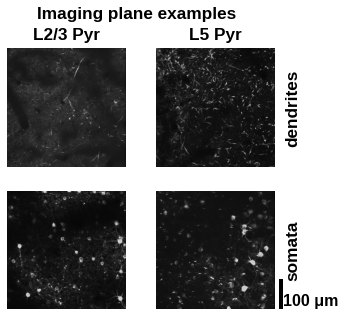

In [7]:
%run run_paper_figures.py --overwrite --figure 1 --panel C --parallel --datadir /content/data --output /content 

### Fig. 2E, but with lower statistical power
Here, we run the analysis without the `--full_power` argument, in order to reduce compute time and memory demands. 

This means that, for this panel, fewer random permutations (here, `1e3` instead of `1e4`) are used in order to calculate each ROI's USI null distribution, and resulting significance percentile. The exact distributions plotted may therefore differ slightly from those plotted in the paper, although they should be qualitatively the same.

The results (analysis data and plot) are saved under a subfolder called `panels_with_diff_params`.



________________________________________________________________________________
Fig. 2E. Running analysis and producing plot: Distributions of Gabor USI percentiles.

- Minor manual formatting adjustments may be missing.
- Reducing number of permutations/shuffles to reduce computation time. This weakens statistical power for significance testing a bit, potentially producing results that differ just slightly from published results. To reproduce paper results exactly, run script with the '--full_power' argument.

Loading 11 session(s)...


  0%|          | 0/11 [00:00<?, ?it/s]


Compiling Gabor ROI USI distributions.
    Calculating ROI USIs and their null distributions for each session...

Figures saved under /content/paper_figures/Fig2/panels_with_diff_params.
Duration: 7m 16.34s


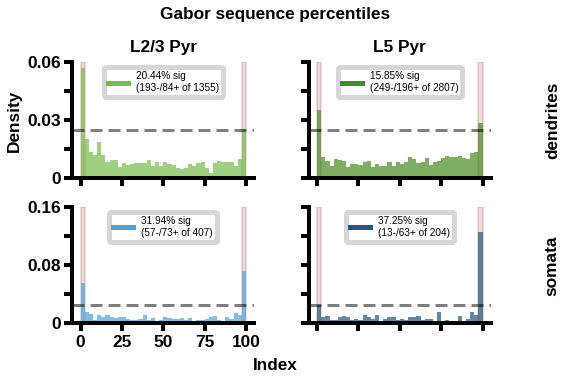

In [8]:
%run run_paper_figures.py --overwrite --figure 2 --panel E --parallel --datadir /content/data --output /content 

### Fig. 3, with full statistical power
Here, we run the analyses with the `--full_power` argument, and thus should be able to exactly reproduce the p-values reported in the paper.



________________________________________________________________________________
Fig. 3A. Running analysis and producing plot: Running and pupil responses to Gabor sequences.

- Minor manual formatting adjustments may be missing.
- Running and pupil images will be missing.

Loading 11 session(s)...


  0%|          | 0/11 [00:00<?, ?it/s]


Compiling pupil and running sequences for session 1.

Figures saved under /content/paper_figures/Fig3.
Duration: 2m 57.29s


Fig. 3B. Running analysis and producing plot: Trial differences in running and pupil responses U-G vs D-G Gabor sequences.

- Minor manual formatting adjustments may be missing.

Compiling pupil and running block differences for session 1.

Raw p-values (two-tailed):
    Running velocity:    L2/3-D: 0.96460       L2/3-S: 0.27680       L5-D: 0.80780       L5-S: 0.44040   
    Pupil diameter  :    L2/3-D: 0.89240       L2/3-S: 0.19560       L5-D: 0.96880       L5-S: 0.26840   

Figures saved under /content/paper_figures/Fig3.
Duration: 53.11s


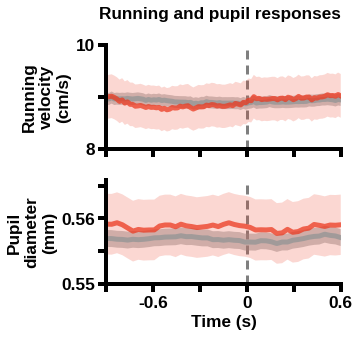

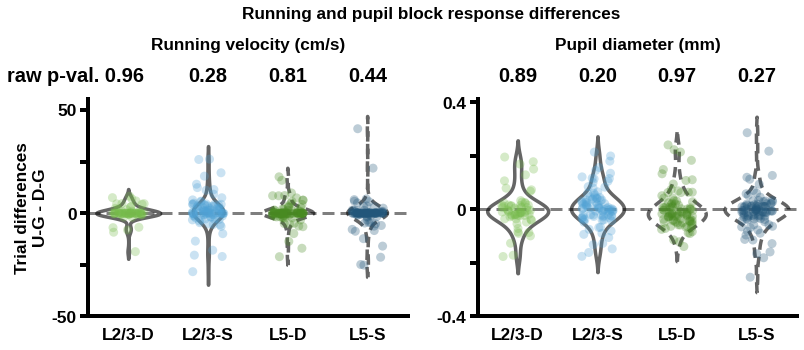

In [9]:
%run run_paper_figures.py --overwrite --figure 3 --panel all --parallel --full_power --datadir /content/data --output /content 

### Fig. 3B, with a different random seed

By default, the script uses the same random process seed as was used for the paper. Here, however, we run the analysis with a different seed, i.e. `100`. This means that the exact p-values obtained may differ slightly from those reported in the paper, although they should be qualitatively the same.

The results (analysis data and plot) are saved under a subfolder called `panels_with_diff_params`, with the seed number recorded in the file names.



________________________________________________________________________________
Fig. 3B. Running analysis and producing plot: Trial differences in running and pupil responses U-G vs D-G Gabor sequences.

- Minor manual formatting adjustments may be missing.
- Using a different seed from the one used in the paper: 100. Results may differ slightly from published results. To use paper seed, run script with default seed argument, i.e., '--seed paper'.

Loading 11 session(s)...


  0%|          | 0/11 [00:00<?, ?it/s]


Compiling pupil and running block differences for session 1.

Raw p-values (two-tailed):
    Running velocity:    L2/3-D: 0.98160       L2/3-S: 0.28240       L5-D: 0.79880       L5-S: 0.44160   
    Pupil diameter  :    L2/3-D: 0.92840       L2/3-S: 0.19920       L5-D: 0.97540       L5-S: 0.28180   

Figures saved under /content/paper_figures/Fig3/panels_with_diff_params.
Duration: 2m 58.22s


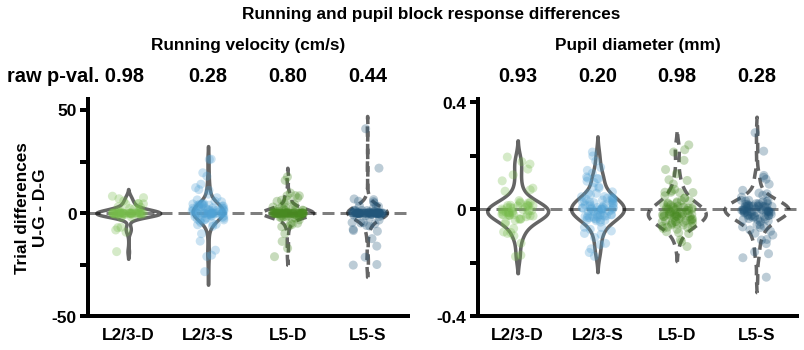

In [10]:
seed = 100
%run run_paper_figures.py --overwrite --figure 3 --panel B --parallel --full_power --seed $seed --datadir /content/data --output /content 

---
# 4. Final Notes

For most other figures and panels, the remaining sessions **(sessions 2 and 3)** must also be downloaded. This can be done by returning to **Step 1d**, and rerunning the download with the argument `--sess_ns 1-3`.

The analyses for some panels are **computationally expensive** (generally, those that involve numerous statistical significance comparisons, e.g. Fig. 4B) or **long** (decoder analyses for Fig. 5A-B), and are best run on a **high-compute device**.